In [1]:
%matplotlib inline



# Profiles for each variable



In [2]:
from pymongo import MongoClient
from __future__ import print_function
from sklearn.externals import joblib
from sklearn.cluster import KMeans
from sklearn import metrics 

import sys
sys.path.append('../../lib')
import rs_common_framework_v4 as rs

import pandas as pd
import datetime
import collections
import numpy as np
import math

from sklearn.decomposition import PCA, IncrementalPCA
from matplotlib import cm, pyplot as plt, style as st, gridspec as gd
from matplotlib.dates import YearLocator, MonthLocator
st.use('seaborn-colorblind')

import plotly.offline as py
import plotly.graph_objs as go  #important library for the plotly
#import cufflinks as cf
import pylab as pl
from IPython.display import display

py.init_notebook_mode(connected=False) # run at the start of every ipython notebook to use plotly.offline
from plotly import tools #to do subplots

from hmmlearn.hmm import GaussianHMM
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

print(__doc__)

Automatically created module for IPython interactive environment


In [3]:
print("\t Connected to Mongo DB")

collection_feature_selection = 'feature_selection'
collection_statistics_daily = 'statistics_daily'
seasons = ['summer', 'winter', 't_period_1', 't_period_2']
day_type = ['working_day', 'weekend', 'holiday']
#day_type = ['working_day']

# select tag name
tag_query = {'category': {'$in': ['Humidity']}, 'floor':1}
path_model = '../../HMM_models/Draft_models/'
file_name = 'hmm_' 

db_name = "project_db"
connection = MongoClient('localhost')  # "192.168.6.132"
collection_metadata = connection[db_name]["metadata"]
collection_series = connection[db_name]["filtered_time_series"]
collection_statistics_general = connection[db_name]["statistics_general"]

collection_statistics_daily = connection[db_name][collection_statistics_daily]
collection_feature_selection = connection[db_name][collection_feature_selection]

	 Connected to Mongo DB


In [4]:
print('Get tag names')
tag_list = rs.get_tag_names(collection_metadata, tag_query)


Get tag names


In [5]:
tag = tag_list[0]
#tag = 'V046_room102_temp'
print('Get model for ', tag)
path_open = path_model + file_name + tag + '.pkl'
print("\tReading the HMM model: \n{0}".format(path_open)) 
model = joblib.load(path_open)
n_comp = model.n_components
n_features = model.n_features

print("\tn_comp = {0}, n_features = {1}".format(n_comp,n_features))

Get model for  V043_room101_hum
	Reading the HMM model: 
../../HMM_models/Draft_models/hmm_V043_room101_hum.pkl
	n_comp = 29, n_features = 24


In [6]:
print('Get vector')

time_query = {
            'seasonal_label':{'$in': seasons},
            'day_type': {'$in': day_type}
            }
timeline = rs.get_timeline(collection_statistics_daily, time_query, freq=None)

df_vector = rs.get_samples(collection_series, tag=tag, timeline=timeline, normalization=False)

X = df_vector.values
print(len(timeline))

Get vector
1081


In [7]:
print("Number of samples to observe: ", len(X))
hidden_states = model.predict(X)
print("\tInfering the hidden states from the observed samples. A sequence of {0} hidden status was infered".format(len(hidden_states)))
df_y = pd.DataFrame(hidden_states, columns=['hidden_states'])
df_y.index = df_vector.index

Number of samples to observe:  1081
	Infering the hidden states from the observed samples. A sequence of 1081 hidden status was infered


In [8]:
s = dict()
for n in range(n_comp):
    s[n] = sum(model.means_[n])
print('Ordering profiles according his respectively mean')
ordered_n_comp = sorted(s,key=s.__getitem__)

Ordering profiles according his respectively mean


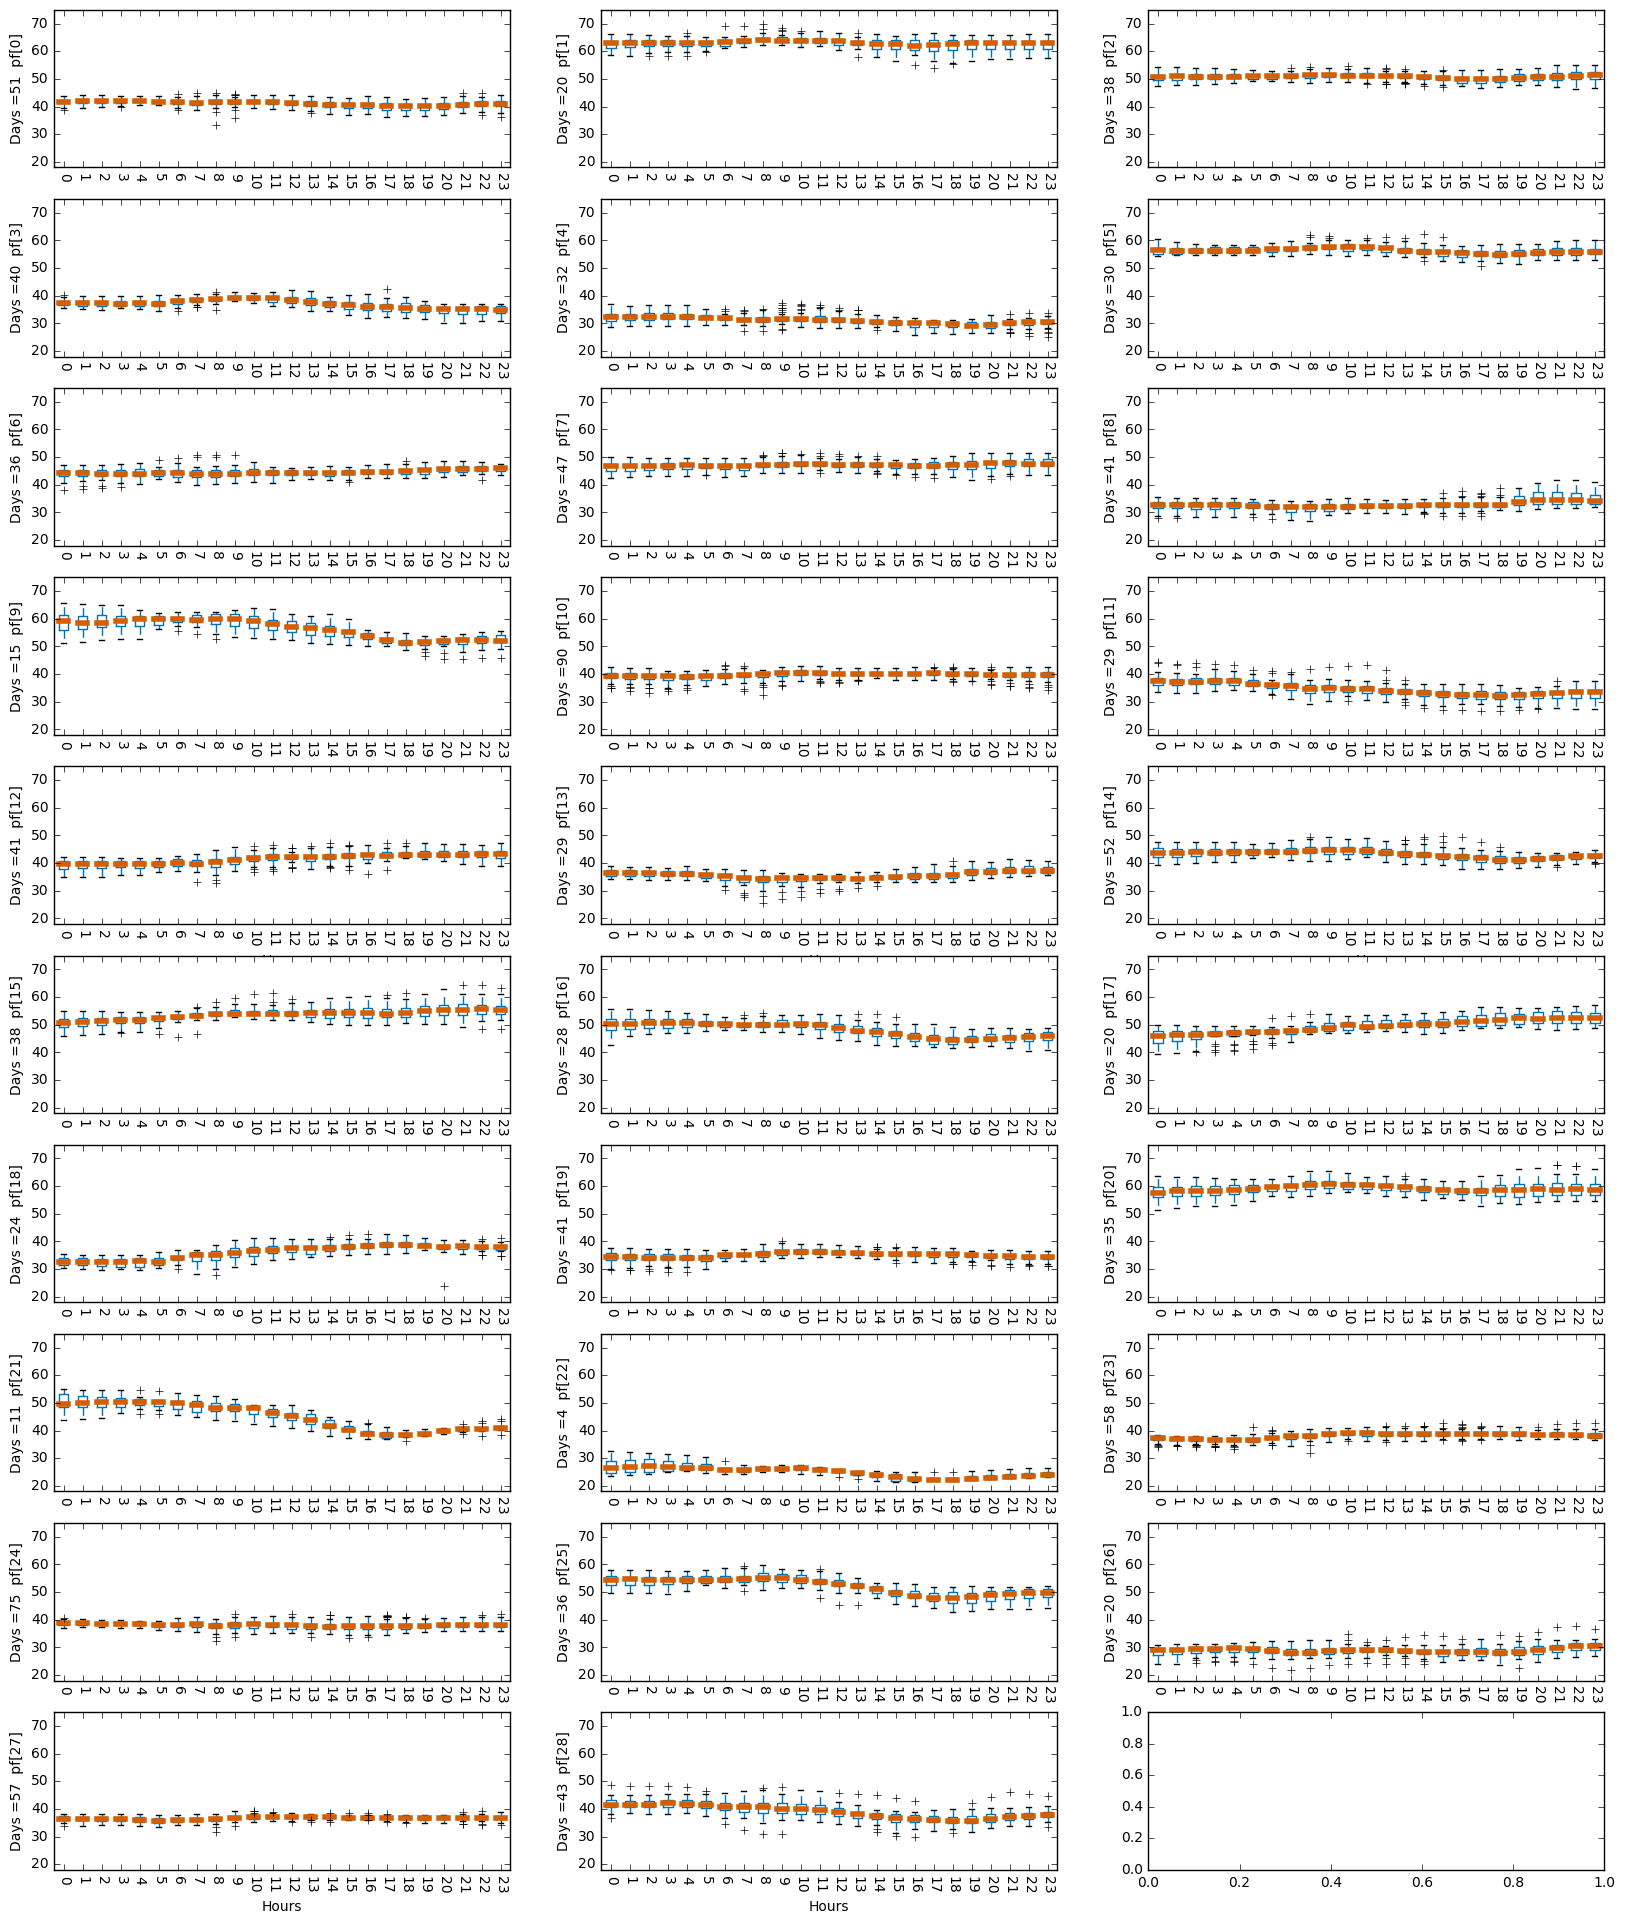

In [9]:
lol, upl = rs.get_lol_upl(collection_statistics_general, tag)
dv = (upl - lol) * 0.3

nrows = int(np.ceil(n_comp/3))
fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(20,24))
medianprops = dict(linewidth=4, color='red')
i = 0
j = 0
for n in range(n_comp):
    mask = df_y[df_y['hidden_states'] == n].index
    if j>2: 
        j=0
        i+=1
    if(len(mask))>0:
        df_x = rs.get_tag_pivoted_values(collection_series, list(mask), tag)
        df_x.plot.box(ax=axes[i][j],notch=False,  medianprops=medianprops, showfliers=True)
        axes[i][j].set_ylim([lol-dv, upl+1.2*dv])   
        axes[i][j].set_xlabel('Hours')
        axes[i][j].set_ylabel('Days =' + str(len(mask)) + '  pf[' + str(n) + ']')
        axes[i][j].set_xticklabels(labels = range(24), rotation=-90)
    j+=1
plt.show()

In [10]:
# print('The clusters that were found are in the following order \n{0}'.format(ordered_n_comp) )

Based on visual observations we spot the following profiles [1, 22, 9, 20]


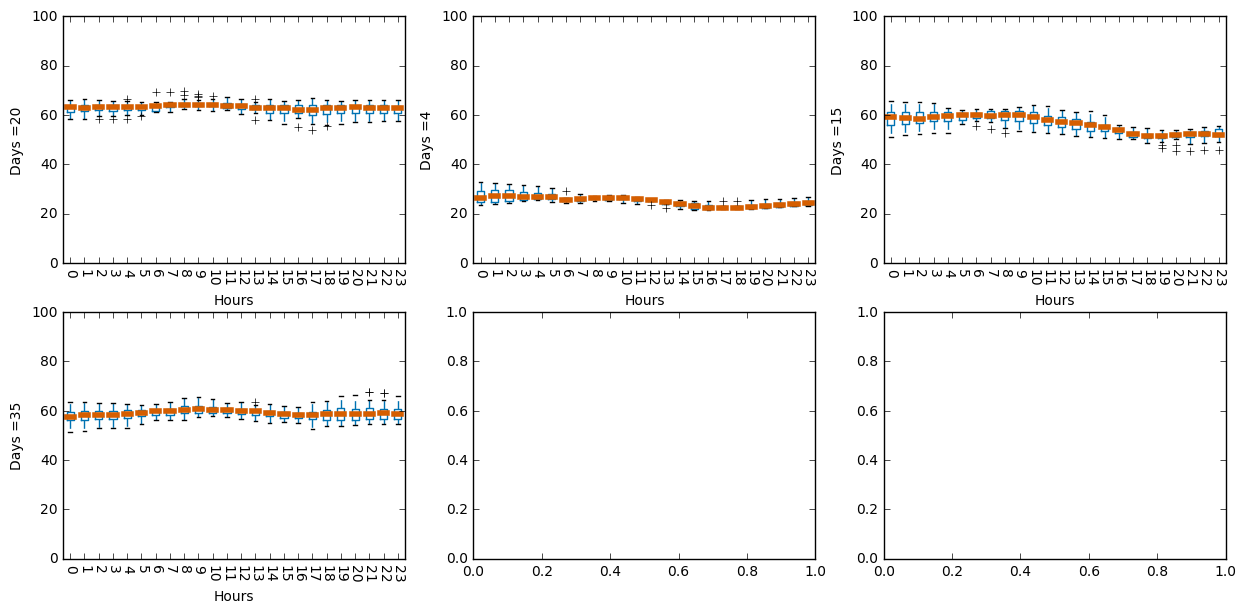

In [16]:
discord_candidates = [1,22, 9, 20]
ylim = [0, 100]
print('Based on visual observations we spot the following profiles {0}'.format(discord_candidates))
nrows = int(np.ceil(len(discord_candidates)/3))
if nrows == 1:
    nrows = 2
    
fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(15,7))
medianprops = dict(linewidth=4, color='red')
i = 0
j = 0

for n in discord_candidates:
    mask = df_y[df_y['hidden_states'] == n].index
    if j>2: 
        j=0
        i+=1
    if(len(mask))>0:
        df_x = rs.get_tag_pivoted_values(collection_series, list(mask), tag)
        df_x.plot.box(ax=axes[i][j],notch=False,  medianprops=medianprops, showfliers=True)
        axes[i][j].set_ylim(ylim)   
        axes[i][j].set_xlabel('Hours')
        axes[i][j].set_ylabel('Days =' + str(len(mask)))
        axes[i][j].set_xticklabels(labels = range(24), rotation=-90)
        j+=1
plt.show()

In [17]:
dates = list()
dates_discord = dict()
for n in discord_candidates:
    mask = df_y[df_y['hidden_states'] == n].index
    if(len(mask))>0:
        dates += list(mask)
        dates_discord[n] = list(mask)
print(dates)

['2012-06-29', '2012-06-30', '2012-07-01', '2012-07-02', '2012-07-03', '2012-07-04', '2012-07-05', '2012-07-06', '2012-08-20', '2012-08-21', '2012-08-22', '2012-08-23', '2012-08-24', '2012-08-25', '2014-07-07', '2014-07-22', '2014-07-23', '2014-08-02', '2014-08-03', '2014-08-04', '2013-02-23', '2015-04-06', '2015-04-07', '2015-04-08', '2012-07-07', '2012-07-09', '2012-07-11', '2012-07-27', '2012-08-15', '2012-08-26', '2013-07-26', '2013-08-19', '2014-07-08', '2014-07-31', '2014-08-11', '2014-08-30', '2014-09-10', '2015-06-06', '2015-06-08', '2012-06-28', '2012-07-08', '2012-07-10', '2012-07-25', '2012-07-26', '2012-07-29', '2012-08-02', '2012-08-03', '2012-08-05', '2012-08-06', '2012-08-13', '2012-08-16', '2012-08-17', '2012-08-19', '2012-08-30', '2012-09-04', '2012-09-05', '2013-06-20', '2013-07-29', '2013-08-05', '2013-08-08', '2013-08-09', '2014-07-05', '2014-07-06', '2014-07-13', '2014-07-14', '2014-07-21', '2014-07-27', '2014-07-28', '2014-07-30', '2014-08-01', '2014-08-10', '2014

In [18]:
print('Define motifs and discords candidates')
candidates =  range(n_comp)
motif_candidates = [x for x in candidates if not x in discord_candidates]
print('motif_candidates:', motif_candidates)
print('discord_candidates:', discord_candidates)

Define motifs and discords candidates
motif_candidates: [0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 23, 24, 25, 26, 27, 28]
discord_candidates: [1, 22, 9, 20]


In [19]:
path_final_model = '../../HMM_models/Draft_models/' + 'named_'
file_name = tag + '.pkl'
print("Save the final model in: " + path_final_model + file_name )
#print("The hidden_state_name: ", label_comp)
final_model = dict()
final_model['model'] = model
final_model['discord_candidates'] = discord_candidates
final_model['motif_candidates'] = motif_candidates 

#save dates when the discord occurs
final_model['dates_discord'] = dates_discord


try:
    joblib.dump(final_model, filename=path_final_model + file_name, compress=3, protocol=2)
except:
    joblib.dump(final_model, filename=file_name, compress=3, protocol=2)
    
#print("Observe the mean vector and variance of each hidden states:")
#for i in motif_candidates:
#    print("{0}th hidden state".format(i+1))
#    print("mean: ", np.round(model.means_[i],1))
#    s = np.diag(model.covars_[i])
#    print("std: ", np.round(s**(0.5),2))
#    print()

Save the final model in: ../../HMM_models/Draft_models/named_V043_room101_hum.pkl
